In [7]:
!pip install segmentation-models-pytorch
!pip install mlflow
!pip install pytorch-lightning
!pip install --upgrade pytorch-lightning


In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nirjarpatel","key":"a24c399e83b88217a912c80c4d3a07f7"}'}

In [13]:
import os
import zipfile

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d intelecai/car-segmentation

# Unzip the downloaded dataset
!unzip car-segmentation.zip -d /kaggle/car-segmentation

Dataset URL: https://www.kaggle.com/datasets/intelecai/car-segmentation
License(s): other
 99% 438M/442M [00:25<00:00, 20.1MB/s]
100% 442M/442M [00:25<00:00, 18.3MB/s]
Archive:  car-segmentation.zip
  inflating: /kaggle/car-segmentation/car-segmentation/classes.txt  
  inflating: /kaggle/car-segmentation/car-segmentation/images/003.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618339-super-purple-modern-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618639-modern-pale-blue-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/156551_preview.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/178583_Side_Profile_Web.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/1965-Shelby-Cobra-Roadster-Side-Profile.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/2008-Morgan-Life-Car-Side-Speed-1024x768.png  
  inflating: /kaggle/car-segmentation/c

In [18]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.cli import LightningCLI
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [20]:
ROOT_DIR =  '/kaggle/car-segmentation/car-segmentation'
BATCH_SIZE = 32

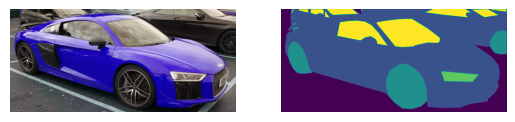

In [21]:
img = cv2.imread(f"{ROOT_DIR}/images/audi-r8-v10-car-side-view.png")
mask = cv2.imread(f"{ROOT_DIR}//masks/audi-r8-v10-car-side-view.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])
plt.axis(False)
plt.show()

In [41]:
class CarData(Dataset):
    def __init__(self,image_dir , mask_dir,size=(256,256)):
      super().__init__()
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.image_list = os.listdir(self.image_dir)
      self.mask_list = os.listdir(self.mask_dir)
      self.transform = transform
      self.size = size

    def __getitem__(self,index):
      img = cv2.imread(self.image_dir+self.image_list[index])
      mask = cv2.imread(self.mask_dir+self.mask_list[index])[:,:,0]
      mask = torch.from_numpy(cv2.resize(mask,self.size)).squeeze().to(torch.long)
      if self.transform:
        img = self.transform(img)
        mask = torch.from_numpy(cv2.resize(mask.numpy(),self.size)).squeeze().to(torch.long)
      return img , mask

    def __len__(self):
      return len(self.image_list)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
  ])
car_data = CarData(f"{ROOT_DIR}/images/",f"{ROOT_DIR}/masks/")
car_dataloader = DataLoader(car_data,batch_size=BATCH_SIZE,shuffle=True)
mlflow_log = MLFlowLogger(experiment_name='Car_Segmentation')

checkpt = ModelCheckpoint(
    monitor='train_loss',
    dirpath='checkpoints',
    filename='smp-{epoch:02d}-{train_loss:.2f}',
    save_top_k=5,
    mode='min',
    verbose=True
)

In [42]:
class SMP(pl.LightningModule):
    def __init__(self, lr=0.001):
        super(SMP, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=5
        )
        self.lr=lr
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
       return optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

In [43]:
model = SMP(lr=0.001)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 0,
    logger=mlflow_log,
    callbacks=[checkpt]
)
trainer.fit(model,car_dataloader)
mlflow.pytorch.log_model(model, "model")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Unet             | 24.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.748    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 7: 'train_loss' reached 1.17247 (best 1.17247), saving model to '/content/checkpoints/smp-epoch=00-train_loss=1.17-v1.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 14: 'train_loss' reached 0.60518 (best 0.60518), saving model to '/content/checkpoints/smp-epoch=01-train_loss=0.61.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 21: 'train_loss' reached 0.40474 (best 0.40474), saving model to '/content/checkpoints/smp-epoch=02-train_loss=0.40.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 28: 'train_loss' reached 0.31122 (best 0.31122), saving model to '/content/checkpoints/smp-epoch=03-train_loss=0.31.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 35: 'train_loss' reached 0.25362 (best 0.25362), saving model to '/content/checkpoints/smp-epoch=04-train_loss=0.25.ckpt' as top 5
INFO:pytorch_lightning.

In [44]:
model.to(device)

SMP(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

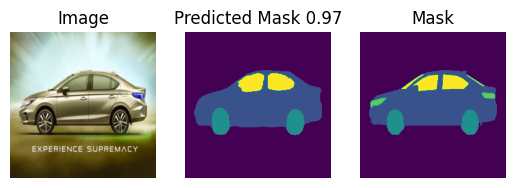

In [45]:
import torch.nn.functional as F
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch.")
        else:

            lenIntersection=0

            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1

            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value
for i in car_dataloader:
    img , _ = i
    plt.subplot(1,3,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('Image')
    plt.axis(False)
    plt.subplot(1,3,2)
    img = img.to(device)
    with torch.no_grad():
        out = model(img)
    probs = F.softmax(out,dim=1)
    out = torch.argmax(probs, dim=1,keepdim=True)
    mask = out.detach().cpu().squeeze()
    dc = dice_coef(_[0],mask[0])
    plt.imshow(mask[0])
    plt.title(f'Predicted Mask {dc:.2f}')
    plt.axis(False)
    plt.subplot(1,3,3)
    plt.imshow(_[0])
    plt.title('Mask')
    plt.axis(False)
    plt.show()
    break

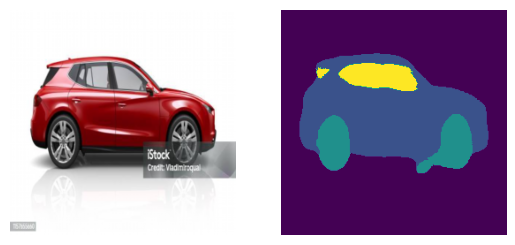

In [48]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
image_url = "https://media.istockphoto.com/id/1157655660/photo/generic-red-suv-on-a-white-background-side-view.jpg?s=612x612&w=is&k=20&c=_Q6TahU4WHmpGOa77nCd24gAyIUDTs1X3RtQUcD4WX0="
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)
transform_img = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((256,256),antialias=True)
      ])
tensor = transform_img(img_array)
with torch.no_grad():
        out = model(tensor.unsqueeze(dim=0).to(device))
probs = F.softmax(out,dim=1)
out = torch.argmax(probs, dim=1,keepdim=True)
mask = out.detach().cpu().squeeze()

plt.subplot(1,2,1)
plt.imshow(tensor.permute(1,2,0).detach().cpu().numpy())
plt.axis(False)


plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis(False)

plt.show()